We will use the same ideas from the previous 3 points

In [3]:

#! pip install -q lalsuite==6.82 bilby==1.0.4 gwpy==2.0.2 matplotlib==3.2.2 dynesty==1.0.0

In [4]:

import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

In [5]:
import numpy as np

In [6]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.filter import sigma
from pycbc.frame import read_frame
import urllib

In [9]:
from pycbc.frame import read_frame
import urllib

def get_file(fname):
    url = "https://www.gw-openscience.org/s/workshop3/challenge/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['challenge1.gwf' , 'challenge3.gwf']

for fname in files:
    get_file(fname)


KeyboardInterrupt: 

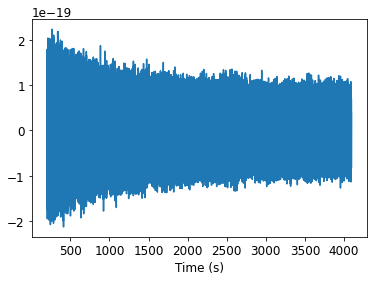

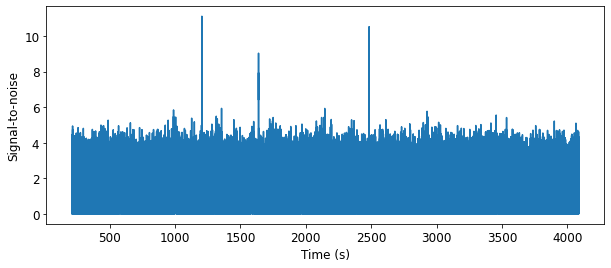

<class 'numpy.float64'>
Mass: 9. We found a signal at 1204.714599609375s with SNR 11.105500260375607
<class 'lal.LIGOTimeGPS'>


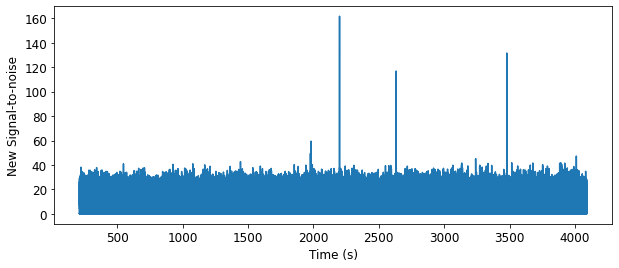

<class 'numpy.float64'>
Mass: 9. We found a signal at 1204.714599609375s with NSNR 25.085485067777906


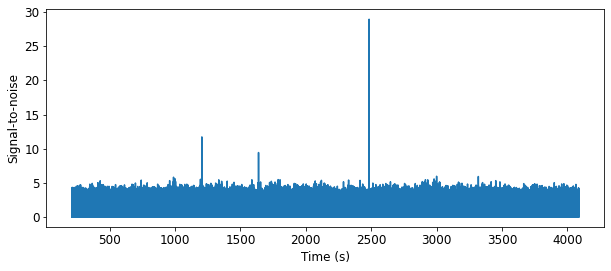

<class 'numpy.float64'>
Mass: 10. We found a signal at 2483.968505859375s with SNR 28.954664844712294
<class 'lal.LIGOTimeGPS'>


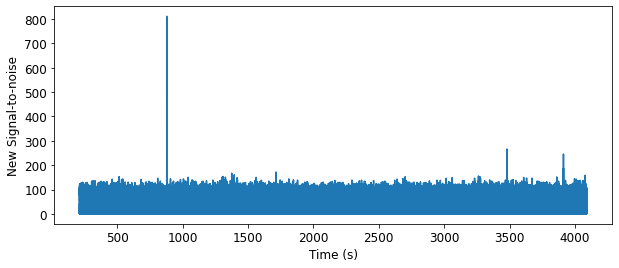

<class 'numpy.float64'>
Mass: 10. We found a signal at 2483.968505859375s with NSNR 45.04982991563908


In [7]:

file_name="challenge3.gwf"
channel_name="H1:CHALLENGE3"
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
from pycbc.types.timeseries import TimeSeries
ts = read_frame(file_name, channel_name)
tempi=[]
strain = highpass(ts, 15.0)
strain = resample_to_delta_t(strain, 1.0/4096)
conditioned = strain.crop(202, 2)
%matplotlib inline
pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)

for m in range (9 , 11):
    hp, hc = get_td_waveform(approximant="IMRPhenomD",
    mass1=m,
    mass2=m,
    delta_t=conditioned.delta_t,
    f_lower=20)
    hp.resize(len(conditioned))
    
    template = hp.cyclic_time_shift(hp.start_time)

    snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
    snr = snr.crop(4 + 4, 4)
    pylab.figure(figsize=[10, 4])
    pylab.plot(snr.sample_times, abs(snr))
    pylab.ylabel('Signal-to-noise')
    pylab.xlabel('Time (s)')
    pylab.show()
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]
    print(type(time))
    
    print("Mass: {}. We found a signal at {}s with SNR {}".format(m, time, abs(snrp)))
    
    chisq = {}
    nbins = 26  #same as in the tutorials
    chisq = power_chisq(hp, conditioned, nbins, psd, low_frequency_cutoff=20.0)
    chisq = chisq.crop(8, 4)
    
    dof = nbins * 2 - 2
    chisq /= dof
    dt = time - snr.start_time
    
    nsnr=TimeSeries(newsnr(abs(snr), chisq), snr.delta_t)
    nsnr.resize(len(snr))
    aligned = nsnr.cyclic_time_shift(dt)
    print(type(dt))
    # scale the template so that it would have SNR 1 in this data
    

    # Scale the template amplitude and phase to the peak value
    aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
    aligned.start_time = snr.start_time   #this is just to have the same timing
    nsnr=aligned
    npeak = abs(nsnr).numpy().argmax()
    nsnrp = nsnr[peak]
    ntime = nsnr.sample_times[peak]
    pylab.figure(figsize=[10, 4])
    pylab.plot(nsnr.sample_times, abs(nsnr))
    pylab.ylabel('New Signal-to-noise')
    pylab.xlabel('Time (s)')
    pylab.show()
    print(type(ntime))
    tempi.append(ntime)
    print("Mass: {}. We found a signal at {}s with NSNR {}".format(m, ntime, abs(nsnrp)))

In [8]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries as TS
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")
import gwpy
print(tempi)

[1204.714599609375, 2483.968505859375]


In [9]:
print(type(conditioned))
print(conditioned.get_end_time())
conditioned=conditioned.crop(2,2)
print(conditioned.get_end_time())
print(conditioned.start_time)
print(conditioned.sample_rate)

<class 'pycbc.types.timeseries.TimeSeries'>
4094
4092
204
4096.0


[1204.714599609375, 2483.968505859375]


00:00 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:00 bilby INFO    : Generating frequency domain strain from given time domain strain.
00:00 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


4096.0
0.0 s
4.0 s
Prior done
Likelihood done.


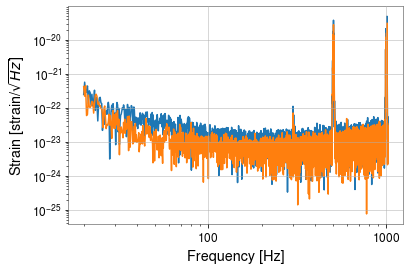

00:00 bilby INFO    : Running for label 'challenge4', output will be saved to 'short'
00:00 bilby INFO    : Using lal version 7.1.7
00:00 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
00:00 bilby INFO    : Using lalsimulation version 3.1.2
00:00 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
00:00 bilby INFO    : Search parameters:
00:00 bilby INFO    :   chirp_mass = UniformInComponentsChirpMass(minimum=15, maximum=25, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
00:00 bilby INFO    :   luminosity_distance = UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (M

In [ ]:
file_name="challenge3.gwf"
channel_name1="H1:CHALLENGE3"
channel_name2="L1:CHALLENGE3"
print(tempi)
ts1 = read_frame(file_name, channel_name1)
ts2 = read_frame(file_name, channel_name2)
duration=4
after_peak=2
strain1 = highpass(ts1, 15.0)
strain1 = resample_to_delta_t(strain1, 1.0/4096)
strain2 = highpass(ts1, 15.0)
strain2 = resample_to_delta_t(strain2, 1.0/4096)
for time in tempi:
    psd_duration = duration * 32
    psd_start_time = time - psd_duration
    print(strain1.duration)
    psd1 = strain1.crop(time-psd_duration , time)
    psd2 = strain2.crop(time-psd_duration, time)
    conditioned1 = strain1.crop(time-duration+after_peak, strain1.get_end_time()-time-after_peak)
    conditioned2 = strain2.crop(time-duration+after_peak, strain2.get_end_time()-time-after_peak)

    


    #psd1 = conditioned1.psd(4)
    #psd1 = interpolate(psd1, conditioned1.delta_f)
    #psd1 = inverse_spectrum_truncation(psd, int(4 * conditioned1.sample_rate), low_frequency_cutoff=15)

    #psd2 = conditioned2.psd(4)
    #psd2 = interpolate(psd2, conditioned2.delta_f)
    #psd2 = inverse_spectrum_truncation(psd, int(4 * conditioned2.sample_rate), low_frequency_cutoff=15)

    #psd1.resize(len(conditioned1))
   #this is just to have the same timing
    #psd1=TS(psd1, sample_rate=4096)

    #psd2.resize(len(conditioned2))
   #this is just to have the same timing
    #psd2=TS(psd2, sample_rate=4096)

    con1_gw=TS(conditioned1, sample_rate=4096)
    
    
    con2_gw=TS(conditioned2, sample_rate=4096)
    print(con1_gw.t0)
    print(con1_gw.duration)
    H1.set_strain_data_from_gwpy_timeseries(con1_gw)
    L1.set_strain_data_from_gwpy_timeseries(con2_gw)
    psd_duration = duration * 32
    psd_start_time = time - psd_duration

    psd1.resize(len(conditioned1))
   #this is just to have the same timing
    psd1=TS(psd1, sample_rate=4096)

    psd2.resize(len(conditioned2))
   #this is just to have the same timing
    psd2=TS(psd2, sample_rate=4096)
    psd_alpha = 2 * H1.strain_data.roll_off / duration
    H1_psd = psd1.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
    L1_psd = psd2.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
    H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
    L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)
    time_of_event=time
    prior = bilby.gw.prior.BBHPriorDict("bbh.prior")
    prior['geocent_time']=Uniform(name="geocent_time", minimum=time_of_event-0.1 , maximum=time_of_event+0.1)
    print("Prior done")
    interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
    waveform_arguments = dict(
        waveform_approximant='IMRPhenomD', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
    waveform_generator = bilby.gw.WaveformGenerator(
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        waveform_arguments=waveform_arguments,
        parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
    likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
        interferometers, waveform_generator, priors=prior,
        time_marginalization=True, phase_marginalization=True, distance_marginalization=False)
    print("Likelihood done.")
    H1.maximum_frequency = 1024
    L1.maximum_frequency = 1024
    fig, ax = plt.subplots()
    idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
    ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
    ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
    plt.show()
    result_short = bilby.run_sampler(
        likelihood, prior, sampler='dynesty', outdir='short', label="challenge4",
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        sample="unif", nlive=500, dlogz=3)
     

In [ ]:
result_short.posterior

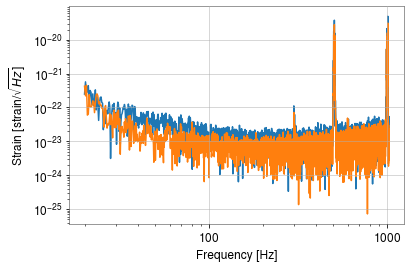

In [27]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()